In [1]:
# %load_ext autoreload
# %autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import json

from matplotlib import cm 
colors = cm.Reds(np.linspace(0.4, 0.9, 10))  # Gradient from light to dark red

import sys
sys.path.append('../../')

from src.viz import (
    plot_transition_matrix,
    plot_distribution,
    plot_implied_timescales,
)
from src.markov_analysis import *

#sns.set(style="white", context="notebook")

def extract_eigen_values(dict_in):
    # Extract spectrum per tau
    spectrum_tau = dict_in["spectrum_tau"]  # keys are strings, e.g. "1", "2", ...
    # Convert tau keys to integers and sort
    tau_list = sorted(map(int, spectrum_tau.keys()))
    # Initialize list of lists: eigval_curves[i][j] = i-th eigval at j-th tau
    eigval_curves = [[] for _ in range(10)]
    for tau in tau_list:
        eigvals = spectrum_tau[str(tau)]
        for i in range(min(10, len(eigvals))):
            eigval_curves[i].append(eigvals[i])
    return eigval_curves,tau_list

In [ ]:

# Load the saved JSON
with open("../../data/copepods/processed/markov_summary.json", "r") as f:
    data = json.load(f)


eigval_curves,tau_list = extract_eigen_values(data)


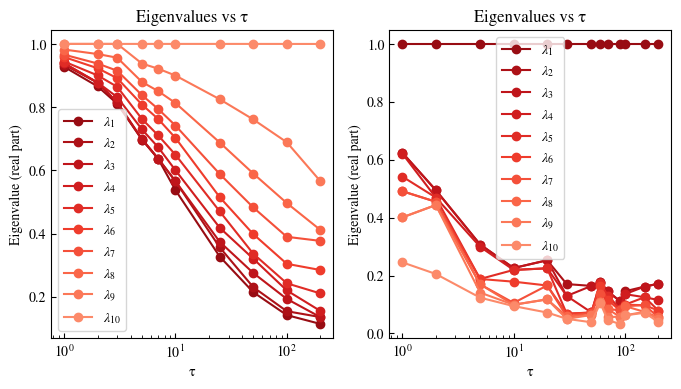

In [ ]:

# Plot
fig,ax = plt.subplots(ncols=1,figsize=(8,4))
for i, eigs in enumerate(eigval_curves):
    ax.plot(tau_list, eigs,marker='o', label=r"$\lambda_{"+str(i+1)+"}$",color=colors[9-i])
ax.set_xlabel("τ")
ax.set_ylabel("Eigenvalue (real part)")
ax.set_title("Eigenvalues vs τ")
ax.set_xscale('log')
ax.legend()


First build the markov model associated with the clustering

In [4]:
# Paths to data from embed_and_cluster.py
with open("../../data/copepods/processed/embedding.pkl", "rb") as f:
        emb = pickle.load(f)
#with open("../../data/copepods/processed/markov.pkl", "rb") as f:
#        mkv = pickle.load(f)


print(f"Labels shape: {emb.labels}")
print(f"Embedding shape: {emb.embedding_matrix.shape}")


Labels shape: [1771 1771 1520 ...  474  474  474]
Embedding shape: (1000, 948, 150)


In [5]:
mkv = Markov(emb,tau=10)

In [6]:
print(mkv.P.shape)
print(emb.embedding_matrix.shape)

(2000, 2000)
(1000, 948, 150)


Now have a look at the stationnary distribution

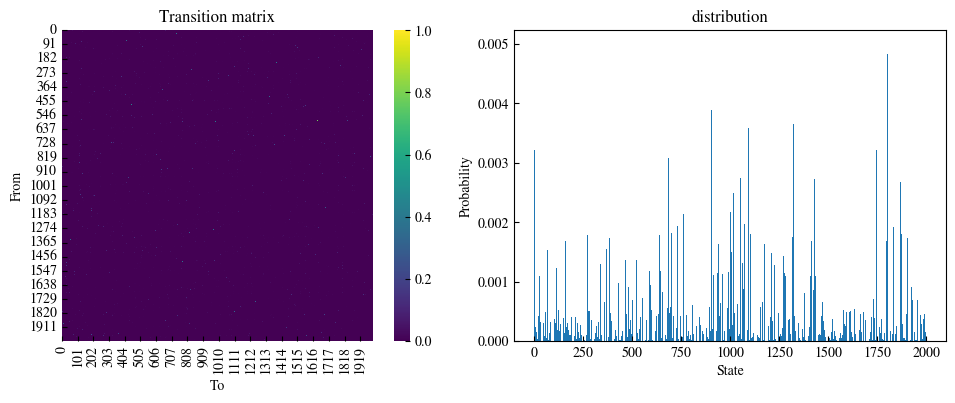

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
plot_transition_matrix(mkv.P, ax=axs[0])
plot_distribution(mkv.pi, ax=axs[1])
plt.tight_layout()


In [8]:
with open("../../data/copepods/processed/embedding.pkl", "wb") as f:
        pickle.dump(emb,f,protocol=pickle.HIGHEST_PROTOCOL)

In [9]:
h = mkv.compute_entropy_rate()
print(f"Shannon entropy rate: {h:.4f} bits per step")


Shannon entropy rate: 3.4976 bits per step


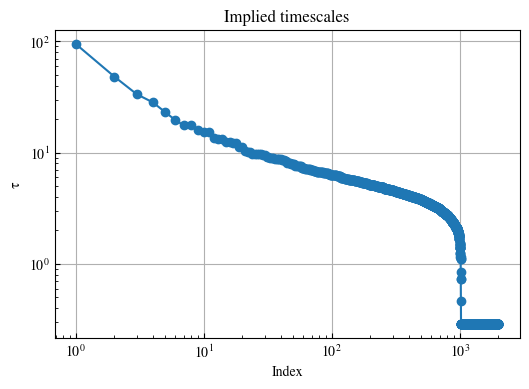

In [15]:
ts = mkv.implied_timescales(tau=mkv.tau)

fig, ax = plt.subplots(figsize=(6, 4))
plot_implied_timescales(ts, ax=ax)
plt.yscale('log')
plt.xscale('log')


Look at the spectrum of the transition matrix.

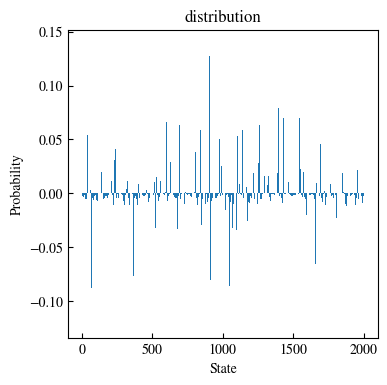

In [11]:
mkv.compute_spectrum()
P_sym = mkv.reversibilized_matrix()
mkv.compute_tr_spectrum()

fig,ax = plt.subplots(figsize=(4,4))
plot_distribution(mkv.tr_slow_mode,ax = ax)
plt.show()

In [12]:
mkv.compute_metastability(time_reversed=True)

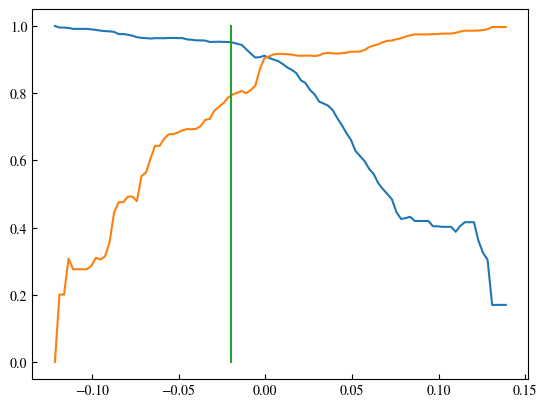

In [60]:
#threshold1 = mkv.thresholds[np.argmax([min(a,b) for a,b in zip(mkv.meta_in,mkv.meta_out)])]
threshold1 = - 0.02
plt.plot(mkv.thresholds,mkv.meta_in)
plt.plot(mkv.thresholds,mkv.meta_out)
plt.plot([threshold1,threshold1],[0,1])

In [61]:
mkv.compute_tr_spectrum()

In [62]:
df = pd.read_csv('../../data/copepods/interim/longest_trajectory.csv')
df.head()

,label,x,y,z,u,v,w,frame,speed,curvature_angle,torsion_angle,abs_torsion_angle
0,3108,26.140147,42.791807,-11.754598,2.759621,-1.476744,-5.764880,1080465,0.033680,1.566962,0.082910,0.082910
1,3108,26.154583,42.782881,-11.749636,2.630041,-1.334178,-3.569576,1080466,0.019668,0.580044,1.238749,1.238749
2,3108,26.166231,42.774990,-11.733177,2.297801,-1.257121,-0.520242,1080467,0.018819,0.123438,-1.158518,1.158518
3,3108,26.173381,42.767849,-11.720790,1.980169,-1.354051,2.444283,1080468,0.018112,0.356532,-0.788438,0.788438
4,3108,26.176693,42.761603,-11.701827,2.095226,-1.571031,6.451247,1080469,0.031320,0.156191,-1.524834,1.524834


In [63]:
labels = emb.classify_trajectory(trajectory_trans=df[['x','y','z']].to_numpy())

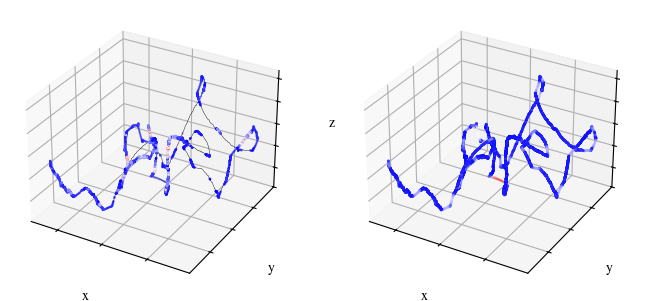

In [64]:
fig, ax = plt.subplots(ncols=2, subplot_kw={'projection': '3d'}, figsize=(8, 4))

color_values = np.array([mkv.tr_slow_mode[lab] for lab in labels])
mask = color_values > threshold1

df_filtered = df.iloc[:len(color_values)].reset_index(drop=True)
x = df_filtered['x'][mask]
y = df_filtered['y'][mask]
z = df_filtered['z'][mask]
c = color_values[mask]

ax[0].scatter(x, y, z,s=0.5, c=c, cmap='bwr')



ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].set_zlabel('z')
ax[0].set_xticklabels([])
ax[0].set_yticklabels([])
ax[0].set_zticklabels([])
ax[0].grid(True)

color_values = df['speed']#[(mkv.tr_slow_mode[lab]) for lab in labels]
I = color_values.__len__()

ax[0].plot(df['x'][:I],df['y'][:I],df['z'][:I],c='black',linewidth=0.3)

ax[1].scatter(df['x'][:I],df['y'][:I],df['z'][:I],c=color_values,cmap='bwr',s=1)
ax[1].set_xlabel('x')
ax[1].set_ylabel('y')
ax[1].set_zlabel('z')
ax[1].set_xticklabels([])
ax[1].set_yticklabels([])
ax[1].set_zticklabels([])
ax[1].grid(True)


In [65]:
print(df['speed'].shape)
print(labels.shape)

(7783,)
(7734,)


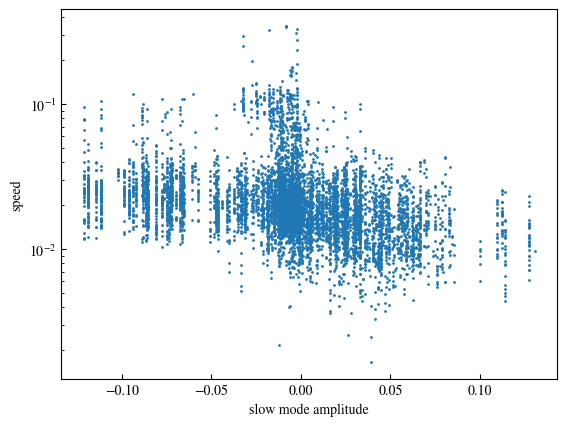

In [66]:
plt.scatter(np.array([mkv.tr_slow_mode[lab] for lab in labels]),df['speed'][:labels.shape[0]],s=1)
#plt.yscale('log')
plt.xlabel('slow mode amplitude')
plt.ylabel('speed')
plt.yscale('log')
#plt.xscale('log')

In [67]:
umap_data = np.load('../../data/copepods/processed/umap_points.npy')
umap_indices = np.load('../../data/copepods/processed/umap_indices.npy')
with open('../../data/copepods/processed/embedding.pkl', "rb") as f:
        emb = pickle.load(f)
umap_cluster_centers = np.load('../../data/copepods/processed/umap_centers.npy')


(948000, 2)


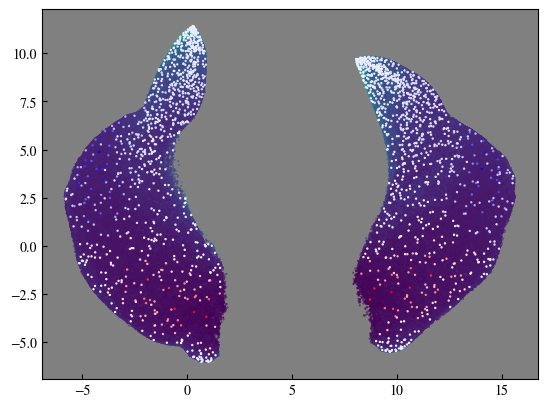

In [68]:
speedx = emb.flatten_embedding_matrix[:,0::3][:,1:] - emb.flatten_embedding_matrix[:,0::3][:,:-1]
speedy = emb.flatten_embedding_matrix[:,1::3][:,1:] - emb.flatten_embedding_matrix[:,1::3][:,:-1]
speedz = emb.flatten_embedding_matrix[:,2::3][:,1:] - emb.flatten_embedding_matrix[:,2::3][:,:-1]
speed = np.mean(np.linalg.norm(np.array([speedx,speedy,speedz]).T,axis=2),axis=0)
color_values=speed

print(umap_data.shape)
#plt.scatter(umap_data[:,0],umap_data[:,1],c=emb.labels[umap_indices],s=0.1)
plt.scatter(umap_data[:,0],umap_data[:,1],c=speed,s=0.1,rasterized=True)
plt.scatter(umap_cluster_centers[:,0],umap_cluster_centers[:,1],c = mkv.tr_slow_mode,s=0.5,cmap='bwr')
ax = plt.gca()
ax.set_facecolor('grey')

In [69]:
S = np.argwhere(mkv.slow_mode<threshold1)[:,0]
P_SS = mkv.P[np.ix_(S,S)]
print(S)
print(mkv.P.shape)
print(P_SS.shape)

[   0    1   16   45   47   53   68   80  113  115  183  194  195  208
  214  218  220  241  246  248  253  257  272  279  304  310  327  353
  366  402  405  428  435  443  449  460  485  489  494  496  522  525
  588  598  624  626  629  636  640  667  672  678  709  738  769  782
  792  805  808  822  838  848  850  869  874  912  934  951  995  998
 1007 1009 1017 1047 1083 1097 1117 1147 1175 1187 1214 1218 1226 1259
 1272 1289 1307 1344 1403 1412 1436 1458 1469 1489 1520 1525 1557 1560
 1578 1582 1597 1605 1648 1652 1657 1679 1727 1746 1763 1779 1789 1794
 1796 1797 1798 1802 1820 1841 1852 1866 1869 1882 1903 1925 1954 1997]
(2000, 2000)
(126, 126)


In [70]:
row_sums = P_SS.sum(axis=1, keepdims=True)
P_SS = np.where(row_sums == 0, 0, P_SS / row_sums)
np.sum(P_SS,axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1.])

In [71]:
mkv_SS = StochasticMatrix(P_SS)
mkv_SS.reversibilized_matrix()
mkv_SS.compute_tr_spectrum()
mkv_SS.compute_spectrum()

In [72]:
mkv_SS.compute_metastability()

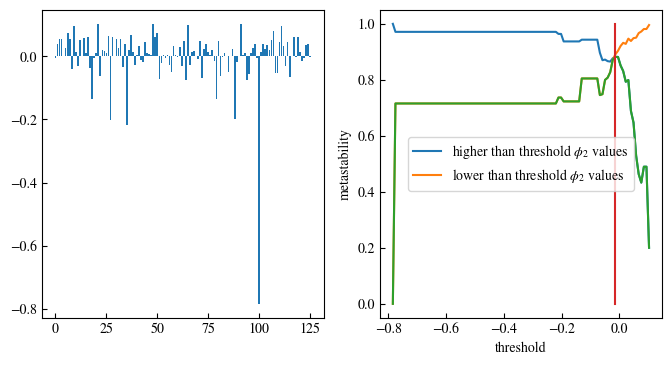

In [73]:
fig,ax = plt.subplots(ncols=2,figsize=(8,4))
ax[0].bar(np.arange(0,mkv_SS.tr_slow_mode.shape[0],1),mkv_SS.tr_slow_mode)

ax[1].plot(mkv_SS.thresholds,mkv_SS.meta_in,label=r'higher than threshold $\phi_2$ values')
ax[1].plot(mkv_SS.thresholds,mkv_SS.meta_out,label=r'lower than threshold $\phi_2$ values')
ax[1].set_xlabel('threshold')
ax[1].set_ylabel('metastability')
ax[1].legend()
threshold2 = mkv_SS.thresholds[np.argmax([min(a,b) for a,b in zip(mkv_SS.meta_in,mkv_SS.meta_out)])]
plt.plot(mkv_SS.thresholds,np.array([min(a,b) for a,b in zip(mkv_SS.meta_in,mkv_SS.meta_out)]))
ax[1].plot([threshold2,threshold2],[0,1])

In [74]:
color_values = np.array([mkv.tr_slow_mode[lab] for lab in labels])

color_values = np.zeros(labels.shape[0],dtype=float)
for s in S[np.argwhere(mkv_SS.slow_mode>=threshold2)[:,0]]:
    color_values[np.argwhere(color_values == s) ] = 1.

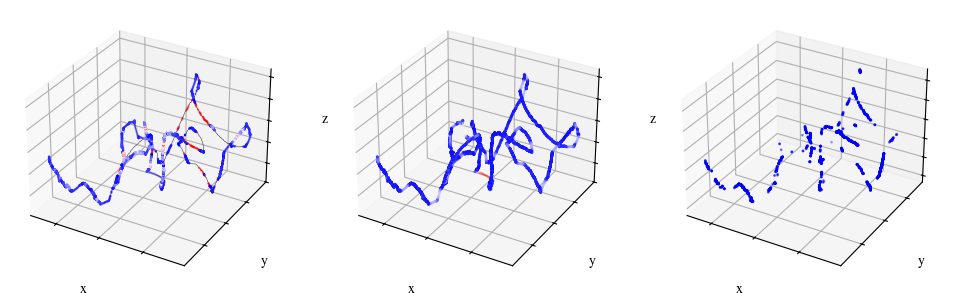

In [75]:
fig, ax = plt.subplots(ncols=3, subplot_kw={'projection': '3d'}, figsize=(12, 4))

color_values = np.array([mkv.tr_slow_mode[lab] for lab in labels])
mask = color_values > threshold1

df_filtered = df.iloc[:len(color_values)].reset_index(drop=True)
x = df_filtered['x'][mask]
y = df_filtered['y'][mask]
z = df_filtered['z'][mask]
c = color_values[mask]

ax[0].scatter(x, y, z,s=0.5, c=c, cmap='bwr')



ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].set_zlabel('z')
ax[0].set_xticklabels([])
ax[0].set_yticklabels([])
ax[0].set_zticklabels([])
ax[0].grid(True)

color_values = df['speed']#[(mkv.tr_slow_mode[lab]) for lab in labels]
I = color_values.__len__()

ax[0].plot(df['x'][:I],df['y'][:I],df['z'][:I],c='black',linewidth=0.3)

ax[1].scatter(df['x'][:I],df['y'][:I],df['z'][:I],c=color_values,cmap='bwr',s=1)
ax[1].set_xlabel('x')
ax[1].set_ylabel('y')
ax[1].set_zlabel('z')
ax[1].set_xticklabels([])
ax[1].set_yticklabels([])
ax[1].set_zticklabels([])
ax[1].grid(True)



#color_values = np.array([mkv_SS.tr_slow_mode[lab] for lab in labels])
color_values = np.zeros(labels.shape[0],dtype=float)
for s in S[np.argwhere(mkv_SS.slow_mode>=threshold2)[:,0]]:
    color_values[np.argwhere(labels == s) ] = 1.

mask = color_values > 0

df1_filtered = df.iloc[:len(color_values)].reset_index(drop=True)
x = df1_filtered['x'][mask]
y = df1_filtered['y'][mask]
z = df1_filtered['z'][mask]
c = color_values[mask]

#ax[0].scatter(x, y, z,s=0.5, c=c, cmap='bwr')

ax[2].scatter(x, y, z, c=c, cmap='bwr', s=1)
ax[0].scatter(x, y, z, c='red', s=0.5,alpha=0.1)
ax[2].set_xlabel('x')
ax[2].set_ylabel('y')
ax[2].set_zlabel('z')
ax[2].set_xticklabels([])
ax[2].set_yticklabels([])
ax[2].set_zticklabels([])
ax[2].grid(True)

(948000, 2)


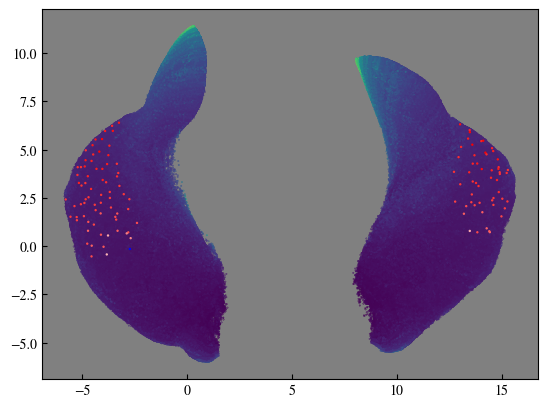

In [76]:
speedx = emb.flatten_embedding_matrix[:,0::3][:,1:] - emb.flatten_embedding_matrix[:,0::3][:,:-1]
speedy = emb.flatten_embedding_matrix[:,1::3][:,1:] - emb.flatten_embedding_matrix[:,1::3][:,:-1]
speedz = emb.flatten_embedding_matrix[:,2::3][:,1:] - emb.flatten_embedding_matrix[:,2::3][:,:-1]
speed = np.mean(np.linalg.norm(np.array([speedx,speedy,speedz]).T,axis=2),axis=0)
color_values=speed

print(umap_data.shape)
#plt.scatter(umap_data[:,0],umap_data[:,1],c=emb.labels[umap_indices],s=0.1)
plt.scatter(umap_data[:,0],umap_data[:,1],c=speed,s=0.1,rasterized=True)
plt.scatter(umap_cluster_centers[:,0][S],umap_cluster_centers[:,1][S],c = mkv_SS.tr_slow_mode,s=0.5,cmap='bwr')
ax = plt.gca()
ax.set_facecolor('grey')